Company XYZ sells a software for 39 dollars. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66 percent of the users have seen the old price (39 dollars), while a random sample of 33 percent users a higher price (59 dollars). The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.


Especially he asked you the following questions:

 1. Should the company sell its software for 39 dollars or 59 dollars?
 
 2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
 
 3. [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, f_classif
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
seed = 42

In [3]:
test_data = pd.read_csv('test_results.csv')

In [4]:
test_data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [5]:
def missing_count(dataset):
    missing ={}
    for col in dataset.columns:
        missing[col] = len(dataset[dataset[col].isnull()])
    return missing

In [6]:
missing_count(test_data)

{'converted': 0,
 'device': 0,
 'operative_system': 0,
 'price': 0,
 'source': 0,
 'test': 0,
 'timestamp': 0,
 'user_id': 0}

We see there are no missing values.

In [7]:
user_data = pd.read_csv('user_table.csv')

In [8]:
user_data.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [9]:
test_data[test_data['test'] == 0].describe()

,user_id,test,price,converted
count,202727.000000,202727.0,202727.000000,202727.000000
mean,499167.741613,0.0,39.020718,0.019904
std,288616.565865,0.0,0.643369,0.139669
min,9.000000,0.0,39.000000,0.000000
25%,249557.000000,0.0,39.000000,0.000000
50%,498452.000000,0.0,39.000000,0.000000
75%,748995.500000,0.0,39.000000,0.000000
max,1000000.000000,0.0,59.000000,1.000000


In [10]:
test_data[test_data['test'] == 1].describe()

,user_id,test,price,converted
count,114073.000000,114073.0,114073.000000,114073.000000
mean,499483.228643,1.0,58.972824,0.015543
std,288547.142025,0.0,0.736735,0.123698
min,3.000000,1.0,39.000000,0.000000
25%,249460.000000,1.0,59.000000,0.000000
50%,500015.000000,1.0,59.000000,0.000000
75%,749093.000000,1.0,59.000000,0.000000
max,999995.000000,1.0,59.000000,1.000000


There are some wrong inputs of indicating whether a person belongs to the test group or control group, as price in test group should be 59 and price in control group should be 39.

In [11]:
test_data[(test_data['price'] == 39) & (test_data['test'] == 1)].head()

,user_id,timestamp,source,device,operative_system,test,price,converted
1457,686486,2015-03-28 15:26:19,seo-other,mobile,android,1,39,0
1912,128338,2015-05-15 11:41:49,direct_traffic,mobile,android,1,39,0
2337,220590,2015-03-27 12:31:43,ads-google,web,windows,1,39,0
3147,246390,2015-05-30 08:29:44,direct_traffic,mobile,iOS,1,39,0
4277,906451,2015-04-05 11:09:18,ads-google,web,windows,1,39,0


In [12]:
index_39 = test_data[(test_data['price'] == 39) & (test_data['test'] == 1)].index

In [13]:
test_data.loc[index_39, 'test'] = 0

In [14]:
test_data[(test_data['price'] == 39) & (test_data['test'] == 1)]

,user_id,timestamp,source,device,operative_system,test,price,converted


In [15]:
test_data[(test_data['price'] == 59) & (test_data['test'] == 0)].head()

,user_id,timestamp,source,device,operative_system,test,price,converted
8238,500863,2015-05-06 22:40:51,ads_other,mobile,iOS,0,59,0
8369,791541,2015-04-13 10:24:19,ads-bing,web,windows,0,59,0
11555,402699,2015-05-16 12:08:45,direct_traffic,mobile,other,0,59,0
12848,624380,2015-05-22 12:37:19,seo-google,mobile,iOS,0,59,0
14630,577544,2015-04-24 17:44:57,seo-google,mobile,android,0,59,0


In [16]:
index_59 = test_data[(test_data['price'] == 59) & (test_data['test'] == 0)].index

In [17]:
test_data.loc[index_59, 'test'] = 1

In [18]:
test_data[(test_data['price'] == 59) & (test_data['test'] == 0)]

,user_id,timestamp,source,device,operative_system,test,price,converted


 Now we've cleaned the data and assigned right indicators of test and control groups according to prices. 

We want to study the distribution of test and control group. First of all, we need to label encode 'source', 'device' and 'operative_system'.

In [19]:
test_new = test_data.copy()
del test_new['timestamp']
test_new.head()

,user_id,source,device,operative_system,test,price,converted
0,604839,ads_facebook,mobile,iOS,0,39,0
1,624057,seo-google,mobile,android,0,39,0
2,317970,ads-bing,mobile,android,0,39,0
3,685636,direct_traffic,mobile,iOS,1,59,0
4,820854,ads_facebook,web,mac,0,39,0


In [20]:
nonnumeric_columns = ['source', 'device','operative_system']

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()

In [23]:
for feature in nonnumeric_columns:
    test_new[feature] = le.fit_transform(test_new[feature])

In [24]:
test_new[test_new['test'] == 0].describe()

,user_id,source,device,operative_system,test,price,converted
count,202672.000000,202672.000000,202672.000000,202672.000000,202672.0,202672.0,202672.000000
mean,499141.681614,4.313581,0.405636,2.344310,0.0,39.0,0.019889
std,288608.634433,3.075330,0.491016,2.061241,0.0,0.0,0.139620
min,9.000000,0.000000,0.000000,0.000000,0.0,39.0,0.000000
25%,249523.000000,1.000000,0.000000,1.000000,0.0,39.0,0.000000
50%,498395.000000,4.000000,0.000000,1.000000,0.0,39.0,0.000000
75%,748921.000000,6.000000,1.000000,5.000000,0.0,39.0,0.000000
max,1000000.000000,11.000000,1.000000,5.000000,0.0,39.0,1.000000


In [25]:
test_new[test_new['test'] == 1].describe()

,user_id,source,device,operative_system,test,price,converted
count,114128.000000,114128.000000,114128.000000,114128.000000,114128.0,114128.0,114128.000000
mean,499529.354751,4.306533,0.421614,2.396958,1.0,59.0,0.015570
std,288561.206978,3.086244,0.493820,2.073733,0.0,0.0,0.123806
min,3.000000,0.000000,0.000000,0.000000,1.0,59.0,0.000000
25%,249529.000000,1.000000,0.000000,1.000000,1.0,59.0,0.000000
50%,500075.000000,4.000000,0.000000,1.000000,1.0,59.0,0.000000
75%,749181.000000,6.000000,1.000000,5.000000,1.0,59.0,0.000000
max,999995.000000,11.000000,1.000000,5.000000,1.0,59.0,1.000000


In [26]:
test_device = test_new.loc[test_new['test'] == 1, 'device']

In [27]:
control_device = test_new.loc[test_new['test'] == 0, 'device']

In [28]:
ss.ttest_ind(test_device, control_device, equal_var = False)

Ttest_indResult(statistic=8.7611061007190933, pvalue=1.94588111186069e-18)

In [29]:
ss.ttest_ind(test_device, control_device, equal_var = False)[1]

1.94588111186069e-18

Since p-value for device is far less than 0.05, splitting two groups is not random based on device.

In [30]:
test_source = test_new.loc[test_new['test'] == 1, 'source']

In [31]:
control_source = test_new.loc[test_new['test'] == 0, 'source']

In [32]:
ss.ttest_ind(test_source, control_source, equal_var = False)[1]

0.53669530554139411

Since p-value for source is far greater than 0.05, splitting two groups based on source is random.

 We see that the difference between test group and control group is quite similar except for the number of people in each group. We confirm that consumers are randomly assigned to control and test groups.

### Next we want to answer the following question:

### Q1. Should the company sell its software for 39 dollars or 59 dollars?

In [33]:
revenues = test_new.groupby(test_new['test']).apply(lambda x: x['converted']*x['price'])
len(revenues[0])   #number of users in control group

202672

In [34]:
control_rev = sum(revenues[0])
control_rev

157209

In [35]:
test_new[test_new['test'] == 0]['converted'].mean()   ### mean convertion rate for control

0.01988927922949396

In [36]:
len(revenues[1])   #number of users in test group

114128

In [37]:
test_rev = sum(revenues[1])
test_rev

104843

In [38]:
test_new[test_new['test'] == 1]['converted'].mean() ## mean conversion rate for test

0.015570236926959203

To illustrate mean revenue in a table:

In [39]:
def group_reve_info(dataset):
    return pd.Series({'no.users': dataset.shape[0],
                     'mean conversion rate': dataset['converted'].mean(),
                     'mean revenue': (dataset['converted']*dataset['price']).mean()                    
                     })
test_new.groupby('test').apply(group_reve_info)

,mean conversion rate,mean revenue,no.users
test,,,
0,0.019889,0.775682,202672.0
1,0.015570,0.918644,114128.0


We want to do a t-test to see whether there's a difference between two groups' mean revenue. The null hypothesis is:

H0: mean revenue of test group is equal to mean revenue of control group.

In [40]:
ttest_mean_rev = ss.ttest_ind(revenues[0], revenues[1], equal_var = False)
ttest_mean_rev

Ttest_indResult(statistic=-5.7703694409395894, pvalue=7.9222577294610276e-09)

In [41]:
ttest_mean_rev[1]

7.9222577294610276e-09

#### Since the p value is much smaller than 0.05, we reject the null hypothesis that the two means are equal. Hence we see conclude that the test group's revenue is greater than the control group. That means there's a positive impact of raising the price, so the company should sell the software at 59 dollars each.

### Now we move on to the second question:
### Q2.  The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

In [42]:
feature_names = ['source','device','price','operative_system']

In [43]:
test_new.loc[:,feature_names].head()

,source,device,price,operative_system
0,3,0,39,1
1,8,0,39,0
2,0,0,39,0
3,5,0,59,1
4,3,1,39,3


In [44]:
test_new.loc[:,feature_names].values

array([[ 3,  0, 39,  1],
       [ 8,  0, 39,  0],
       [ 0,  0, 39,  0],
       ..., 
       [ 1,  1, 39,  3],
       [ 6,  0, 39,  0],
       [ 3,  0, 59,  0]])

In [45]:
test_new['converted'].values

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
chi2_stat, p_value = chi2(test_new.loc[:,feature_names].values, test_new['converted'].values)
pd.DataFrame({'chi2_stats': chi2_stat, 'p_values': p_value}, index = feature_names).sort_values(by = 'p_values')

,chi2_stats,p_values
price,150.992849,1.051844e-34
operative_system,7.642955,5.699447e-03
source,2.373391,1.234187e-01
device,0.729490,3.930485e-01


We see that since price, operative_system has p values smaller than 0.05, they are dependent of the final convertion.

In [47]:
conv_by_price = test_new.groupby('price')['converted'].apply(lambda x: x.mean())

In [48]:
conv_by_price

price
39    0.019889
59    0.015570
Name: converted, dtype: float64

 We see that the convertion rate for low price is higher than for high price.

In [49]:
conv_by_os = test_new.groupby('operative_system')['converted'].apply(lambda x: x.mean())
conv_by_os

operative_system
0    0.014933
1    0.022322
2    0.008222
3    0.023998
4    0.012960
5    0.016955
Name: converted, dtype: float64

In [50]:
sorted(conv_by_os, reverse= True)

[0.023998405421566674,
 0.022322317079557952,
 0.016954523847250831,
 0.014932941882965237,
 0.012959763021476179,
 0.0082224909310761787]

In [51]:
name_os ={'iOS': 1, 'android': 0, 'linux': 2, 'mac': 3, 'windows': 5, 'other': 4} 

we see that mac and ios system leads to much higher convertion rate than other systems, Linux users are least likely to convert.

In [52]:
#test_new[test_new['operative_system']==2].index

In [53]:
#test_new[test_new['operative_system']==4].index

In [54]:
#L = list(le.inverse_transform(test_new['operative_system']))
#L[76]

In [55]:
#L[32]

### Build a model to check convertion

In [56]:
test_model = test_data.copy()
test_model.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [57]:
test_model = test_model.drop('timestamp',1)

In [58]:
test_model.head()

,user_id,source,device,operative_system,test,price,converted
0,604839,ads_facebook,mobile,iOS,0,39,0
1,624057,seo-google,mobile,android,0,39,0
2,317970,ads-bing,mobile,android,0,39,0
3,685636,direct_traffic,mobile,iOS,1,59,0
4,820854,ads_facebook,web,mac,0,39,0


In [59]:
feature_list = ['user_id']

In [60]:
test_model = pd.get_dummies(test_model)

In [61]:
test_model = test_model.drop(feature_list, axis = 1)

In [62]:
test_model.head()

,test,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,...,source_seo-yahoo,source_seo_facebook,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
0,0,39,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0,39,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,39,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,1,59,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
4,0,39,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [63]:
label = test_model.loc[:,'converted']

In [64]:
converted_raw = test_model[test_model['converted'] == 1]
not_converted_raw = test_model[test_model['converted'] == 0]

In [65]:
percentage = len(converted_raw)/float(len(not_converted_raw))

In [66]:
converted = converted_raw
not_converted = not_converted_raw.sample(frac = percentage, random_state = 42)
new_data = converted.append(not_converted)

In [67]:
new_data.head()

,test,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,...,source_seo-yahoo,source_seo_facebook,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
7,1,59,1,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
13,0,39,1,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
46,1,59,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
78,0,39,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
107,0,39,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [68]:
new_data.shape

(11616, 23)

In [69]:
X = new_data.loc[:,test_model.columns != 'converted']
y =new_data.loc[:,'converted']

In [70]:
X.columns

Index([u'test', u'price', u'source_ads-bing', u'source_ads-google',
       u'source_ads-yahoo', u'source_ads_facebook', u'source_ads_other',
       u'source_direct_traffic', u'source_friend_referral', u'source_seo-bing',
       u'source_seo-google', u'source_seo-other', u'source_seo-yahoo',
       u'source_seo_facebook', u'device_mobile', u'device_web',
       u'operative_system_android', u'operative_system_iOS',
       u'operative_system_linux', u'operative_system_mac',
       u'operative_system_other', u'operative_system_windows'],
      dtype='object')

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
train_data, validation_data, train_label, validation_label \
= train_test_split(X, y, test_size = 0.2, random_state = 42)

In [73]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV

In [75]:
clf_DT = DecisionTreeClassifier()

In [76]:
clf_DT.fit(train_data, train_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [77]:
predictions_2 = clf_DT.predict(validation_data)

In [78]:
print(accuracy_score(validation_label, predictions_2))

0.573149741824


In [79]:
roc_auc_score(validation_label, predictions_2)

0.57345344009489918

In [80]:
f1_score(validation_label, predictions_2)

0.57715260017050307

In [81]:
from sklearn.metrics import classification_report

In [82]:
classification_report(validation_label, predictions_2)

'             precision    recall  f1-score   support\n\n          0       0.56      0.58      0.57      1124\n          1       0.59      0.56      0.58      1200\n\navg / total       0.57      0.57      0.57      2324\n'

In [83]:
feature_importance = pd.Series(clf_DT.feature_importances_, index = X.columns).sort_values(ascending=False)

In [84]:
feature_importance

source_friend_referral      0.299973
operative_system_iOS        0.112002
operative_system_mac        0.081536
source_ads_facebook         0.068056
price                       0.060586
source_ads-google           0.060556
operative_system_windows    0.043653
source_direct_traffic       0.031744
source_ads_other            0.030847
test                        0.030524
operative_system_linux      0.026856
source_ads-bing             0.023704
source_seo-yahoo            0.022860
source_ads-yahoo            0.016783
source_seo_facebook         0.015123
operative_system_android    0.013995
source_seo-bing             0.012826
device_web                  0.012745
source_seo-google           0.011899
source_seo-other            0.011680
operative_system_other      0.008815
device_mobile               0.003238
dtype: float64

In [85]:
feature_importance[:6].index

Index([u'source_friend_referral', u'operative_system_iOS',
       u'operative_system_mac', u'source_ads_facebook', u'price',
       u'source_ads-google'],
      dtype='object')

In [86]:
new_train_data=train_data[feature_importance[:6].index]
new_validation_data=validation_data[feature_importance[:6].index]

In [87]:
new_train_data.head()

,source_friend_referral,operative_system_iOS,operative_system_mac,source_ads_facebook,price,source_ads-google
133750,0,1,0,0,59,1
150017,0,0,0,0,59,0
284512,0,0,0,0,39,0
178721,1,0,0,0,39,0
113008,0,1,0,0,39,0


In [88]:
clf = DecisionTreeClassifier(max_depth = 6)#
clf.fit(new_train_data,train_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [89]:
print(accuracy_score(validation_label,clf.predict(new_validation_data)))

0.581755593804


In [90]:
roc_auc_score(validation_label,clf.predict(new_validation_data))

0.58308274021352313

In [91]:
f1_score(validation_label,clf.predict(new_validation_data))

0.57255936675461749

In [92]:
model_DT=clf.fit(new_train_data,train_label)

In [93]:
target_name=['not_converted','converted']

In [94]:
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

In [95]:
def plot_tree(decision_tree, out_file=None, max_depth=None,
              feature_names=None, class_names=None, label='all',
              filled=True, leaves_parallel=False, impurity=True,
              node_ids=False, proportion=False, rotate=False,
              rounded=True, special_characters=True):
    
    dot_data = tree.export_graphviz(decision_tree, out_file=out_file,
                                    max_depth=max_depth, feature_names=feature_names,
                                    class_names=class_names, label=label, filled=filled,
                                    leaves_parallel=leaves_parallel, impurity=impurity, node_ids=node_ids,
                                    proportion=proportion, rotate=rotate, rounded=rounded,
                                    special_characters=special_characters)
    graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph.create_png())

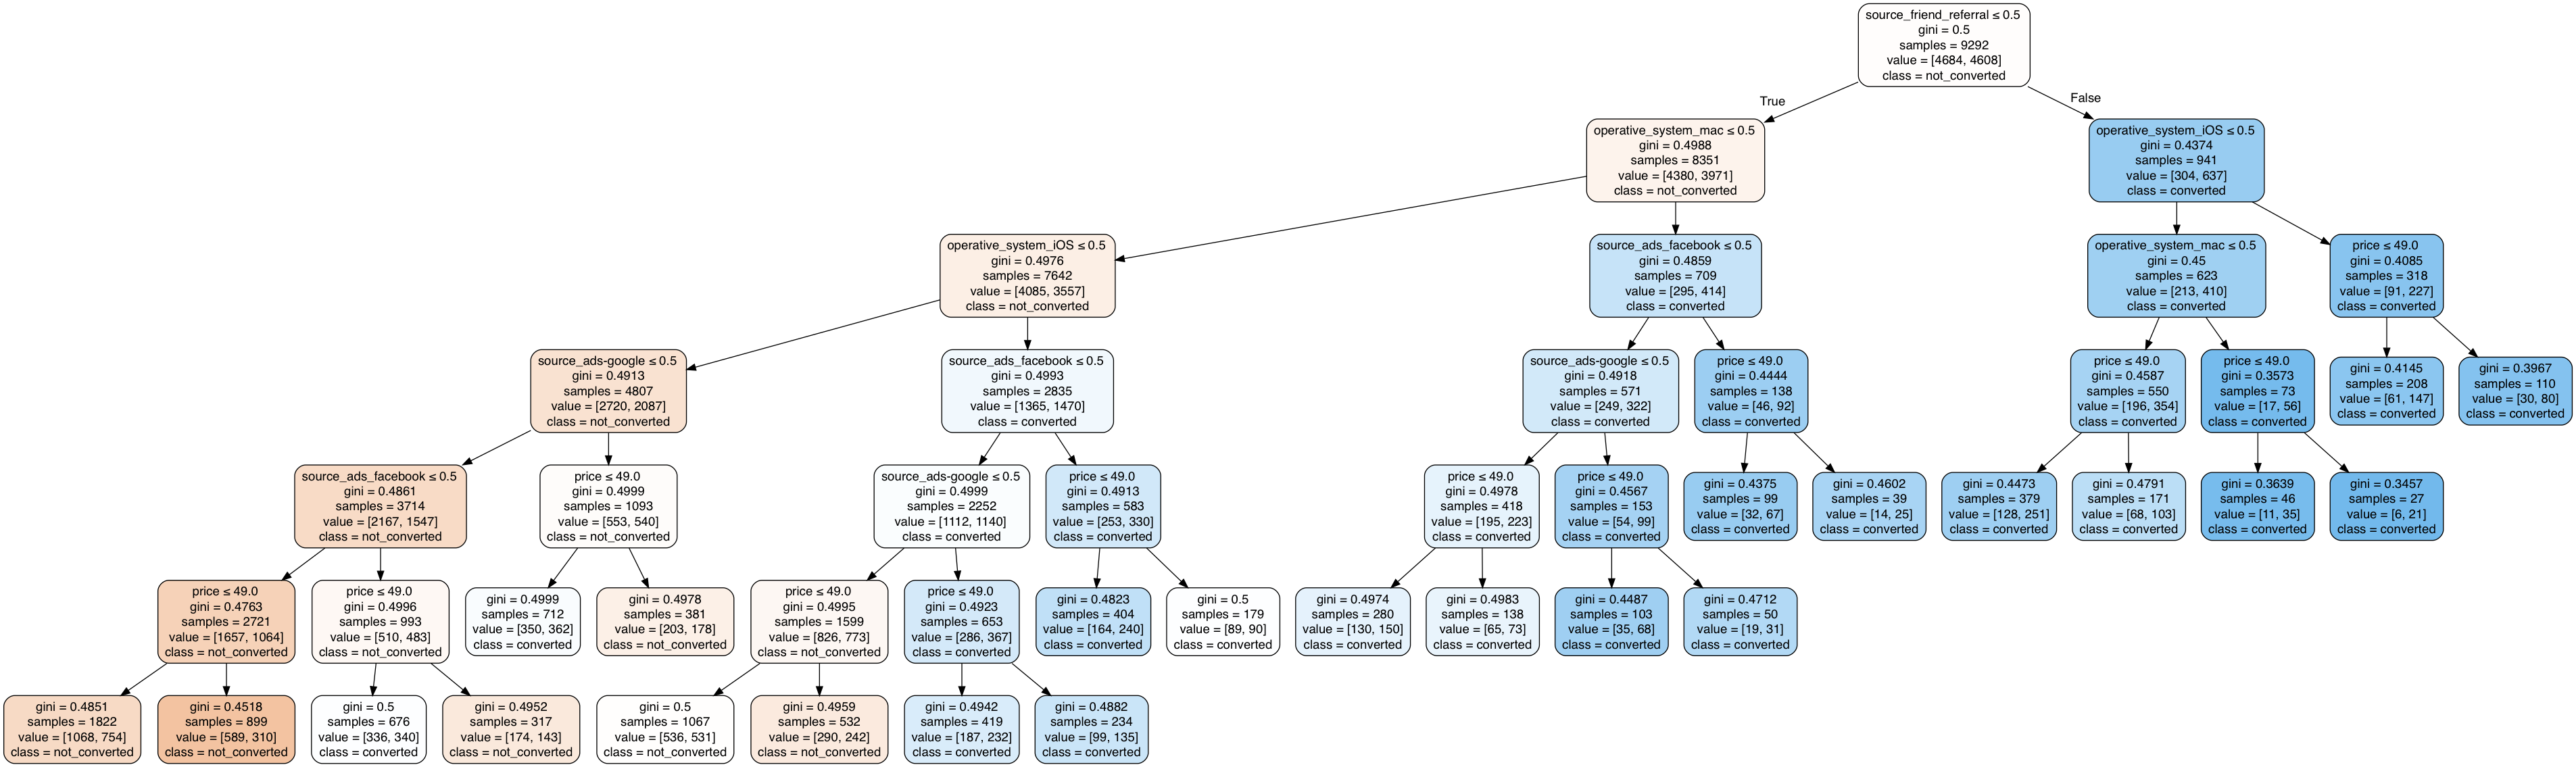

In [96]:
plot_tree(model_DT,out_file=None,feature_names=new_train_data.columns,class_names=target_name)

### From the decision tree graph, we actually find some patterns:
1. Friends' referrals are very important. With friends' referral, the likelihood to convert is high.
2. The operative systems are important, mac system users are more likely to convert. IOS users learning from ads source(Facebook and Google) or combined with low price offer are more likely to convert.
3. If the customer does not use either Mac or iOS, then ads is very important in the role of convertion. Otherwise, even if the price is low, the user is unlikely to convert.

### Actions:
1. Try to run Friends' reward system, that people are more likely to invite their friends to the program if they are rewarded for this action.
2. Try to target more Apple users.
3. Try to increase Google and Facebook ads.
4. Try to figure out why Linux users are least likely to convert. Is there a compatibility issue there?
5. Think about ways to engage Windows and Android users to the program.Think about why those users are less likely to convert. Is it because the platform for ads are less good? 

### Q3: [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

In [97]:
test_new['timestamp'] = test_data['timestamp']

In [98]:
test_new['Year'] = test_new.timestamp.apply(lambda x: x.split(' ')[0].split('-')[0])

In [99]:
test_new['Month'] = test_new.timestamp.apply(lambda x: x.split(' ')[0].split('-')[1])

In [100]:
test_new['Day'] = test_new.timestamp.apply(lambda x: int(x.split(' ')[0].split('-')[2]))

### We consider the dataset containing only one month and two months.

In [101]:
test_1_month = test_new[test_new['Month']=='03']
test_2_month= test_new.loc[test_new['Month']!= '05']

In [102]:
revenues_1_month = test_1_month.groupby(test_1_month['test']).apply(lambda x: x['converted']*x['price'])

In [103]:
revenues_2_month = test_2_month.groupby(test_2_month['test']).apply(lambda x: x['converted']*x['price'])

In [104]:
ttest_mean_rev_1_month = ss.ttest_ind(revenues_1_month[0], revenues_1_month[1], equal_var = False)
ttest_mean_rev_1_month[1]

2.3929166065367509e-05

In [105]:
ttest_mean_rev_2_month = ss.ttest_ind(revenues_2_month[0], revenues_2_month[1], equal_var = False)
ttest_mean_rev_2_month[1]

6.7643065702210346e-06

### We see that if we just run for just one month we can have statistical significant results, since p-values 2.3929166065367509e-05 and 6.7643065702210346e-06 are all smaller than 0.05. 

In [106]:
test_15_days = test_1_month[test_1_month['Day']<16]

In [107]:
revenues_15_days = test_15_days.groupby(test_15_days['test']).apply(lambda x: x['converted']*x['price'])

In [108]:
len(revenues_15_days)

48992

In [109]:
ttest_mean_rev_15_days = ss.ttest_ind(revenues_15_days[0], revenues_15_days[1], equal_var = False)
ttest_mean_rev_15_days[1]

0.00074497412441532659

#### This means we fewer less than 15 days to reach statistical significant results, as the p-value is smaller than 0.05.

In [110]:
test_5_days = test_1_month[test_1_month['Day']<6]

In [111]:
len(test_5_days)

7319

In [112]:
revenues_5_days = test_5_days.groupby(test_5_days['test']).apply(lambda x: x['converted']*x['price'])

In [113]:
ttest_mean_rev_5_days = ss.ttest_ind(revenues_5_days[0], revenues_5_days[1], equal_var = False)
ttest_mean_rev_5_days[1]

0.79152697847176046

### This shows we need more than 5 days to reach statistical significant results, as the p-value is greater than 0.05.

In [114]:
def compute(day):
    subset = test_1_month[test_1_month['Day'] < day]
    revenue = subset.groupby(subset['test']).apply(lambda x: x['converted']*x['price'])
    ttest = ss.ttest_ind(revenue[0],revenue[1], equal_var= False)
    return ttest[1]

In [115]:
for i in range(5,15):
    if compute(i)< 0.05:
        print i

8
9
10
11
12
13
14


### The above shows we need just 8-1 =7 days to reach statistical significant results.

In [116]:
test_7_days = test_1_month[test_1_month['Day']<8]

In [117]:
len(test_7_days)

20221

In [118]:
len(test_7_days[test_7_days['test'] == 1])   #number of users in test group

7379

In [119]:
len(test_7_days[test_7_days['test'] == 0])   #number of users in control group

12842